# Monte Carlo simulation MAMR1C 2T

<img src="MAR1C-RN.PNG" width="400"> 

In [138]:
__author__ ='Sung Chung'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import datetime

pd.set_option('display.max_column',500)

### input 
V0=100

T0=0
PCM_FACTOR =1.0
num_samples=10000

RT_dTdW=108*PCM_FACTOR                             #RTG dT / dW slope   
RS_dTdW=62*PCM_FACTOR                             #RSG dT / dW slope 


RT, RT_sigma = 11.37,0.5  
RT0, RT0_sigma = 1.2, 0.06 
RTC, RTC_sigma = 10.17, 0.01  
RS, RS_sigma = 2.50, 0.1 
RS0, RS0_sigma = 1.00, 0.05  
RSC, RSC_sigma = 6, 0.01 
RL0,RL0_sigma=1.45,0.075
RM0,RM0_sigma=2.49,0.125  

# RT, RT_sigma = 11.37,2  
# RT0, RT0_sigma = 1.2, 0.06 
# RTC, RTC_sigma = 0.1, 0.01  
# RS, RS_sigma = 2.50, 0.5 
# RS0, RS0_sigma = 1.00, 0.05  
# RSC, RSC_sigma = 0.06, 0.01 
# RL0,RL0_sigma=1.45,0.075
# RM0,RM0_sigma=2.49,0.125  

# RT, RT_sigma = 11.37,2  
# RT0, RT0_sigma = 1.2, 0.06 
# RTC, RTC_sigma = 0.1, 0.01  
# RS, RS_sigma = 2.50, 0.5 
# RS0, RS0_sigma = 1.00, 0.05  
# RSC, RSC_sigma = 0.06, 0.01 
# RL0,RL0_sigma=1.45,0.075
# RM0,RM0_sigma=2.49,0.125  



# RT, RT_sigma = 11.37,2.2  
# RT0, RT0_sigma = 1.2, 0.03 
# RTC, RTC_sigma =0.1, 0.01
# RS, RS_sigma = 2.50, 0.5
# RS0, RS0_sigma = 2.78, 0.07  
# RSC, RSC_sigma = 0.1, 0.01 
# RL0,RL0_sigma=1.45,0.036
# RM0,RM0_sigma=2.49,0.062 

RT, RT_sigma = 11.37,2.2  
RT0, RT0_sigma = 1.2, 0.06 
RTC, RTC_sigma = 10.17, 0.01  
RS, RS_sigma = 2.50, 0.5 
RS0, RS0_sigma = 1.00, 0.05  
RSC, RSC_sigma = 6, 0.01 
RL0,RL0_sigma=1.45,0.075
RM0,RM0_sigma=2.49,0.125  



def getSTOR(TG_R,SG_R,RL):
    TG_SG_resistance =  (TG_R)*(SG_R)/(TG_R+SG_R)
    STOR= (RL+TG_SG_resistance)
    return (TG_SG_resistance, STOR)

#normal distribution b 
RT_n=np.random.normal(RT,RT_sigma,num_samples)
RT0_n=np.random.normal(RT0,RT0_sigma,num_samples)
RTC_n=np.random.normal(RTC,RTC_sigma,num_samples)
RS_n=np.random.normal(RS,RS_sigma,num_samples)
RS0_n=np.random.normal(RS0,RS0_sigma,num_samples)
RSC_n=np.random.normal(RSC,RSC_sigma,num_samples)
RL0_n=np.random.normal(RL0,RL0_sigma,num_samples)
RM0_n=np.random.normal(RM0,RM0_sigma,num_samples)


df=pd.DataFrame({'RT':RT_n,'RT0':RT0_n,'RTC':RTC_n,'RS':RS_n,'RS0':RS0_n, 'RSC':RSC_n,'RL0':RL0_n,'RM0':RM0_n})

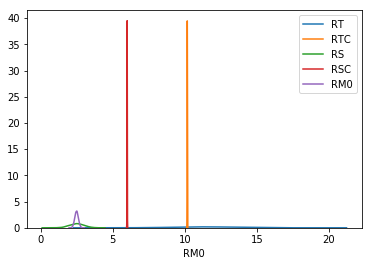

In [139]:
sns.distplot(df['RT'],hist=False,label="RT");
sns.distplot(df['RTC'],hist=False,label="RTC");
sns.distplot(df['RS'],hist=False,label="RS");
sns.distplot(df['RSC'],hist=False,label="RSC");
ax=sns.distplot(df['RM0'],hist=False,label="RM0");

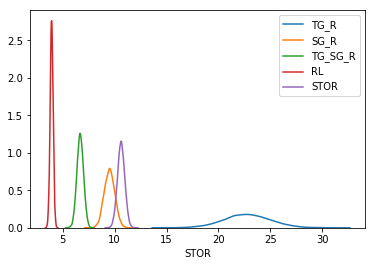

In [140]:
df['RTL']=df['RT0']+df['RTC']
df['RSL']=df['RS0']+df['RSC']

df['TG_R']=df['RT']+df['RTL']
df['SG_R']=df['RS']+df['RSL']
df['RL']=df['RL0']+df['RM0']
ans=np.vectorize(getSTOR)

df['TG_SG_R']=ans(df.TG_R,df.SG_R,df.RL)[0]
df['STOR']=ans(df.TG_R,df.SG_R,df.RL)[1]

sns.distplot(df['TG_R'],hist=False,label="TG_R");
sns.distplot(df['SG_R'],hist=False,label="SG_R");
sns.distplot(df['TG_SG_R'],hist=False,label="TG_SG_R");
sns.distplot(df['RL'],hist=False,label="RL");
sns.distplot(df['STOR'],hist=False,label="STOR",);

# df.describe().round(2)

In [141]:
# Io can be calculated based on voltage at RT



<img src="simpleSTOR.PNG" width=500> 

In [142]:
# Calculate T-Slope for SG and TG (deltaT/deltaT)
df['bias_current']=V0/df['TG_SG_R']



df['TG_iRatio']=df['SG_R']/(df['TG_R']+df['SG_R'])
df['SG_iRatio']=1-df['TG_iRatio']
df['iTG']=df['bias_current']*df['TG_iRatio']
df['iSG']=df['bias_current']-df['iTG']

df['pwRTG']=(df['iTG']**2)*df['RT']/1000
df['pwRSG']=(df['iSG']**2)*df['RS']/1000

df['dT_RTG']=RT_dTdW*df['pwRTG']
df['dT_RSG']=RS_dTdW*df['pwRSG']
df['dTemp']=df['dT_RTG']+df['dT_RSG']
df['Temp']=df['dTemp']+T0

now=datetime.datetime.now()
month=now.month
day=now.day
second=now.second
df.to_csv(fname + "-{}-{}_{}sec.csv".format(month, day, second))
df.describe()

,RT,RT0,RTC,RS,RS0,RSC,RL0,RM0,RTL,RSL,TG_R,SG_R,RL,TG_SG_R,STOR,bias_current,TG_iRatio,SG_iRatio,iTG,iSG,pwRTG,pwRSG,dT_RTG,dT_RSG,dTemp,Temp
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,11.388899,1.199630,10.170171,2.505934,1.000008,5.999947,1.449256,2.490179,11.369801,6.999955,22.758700,9.505889,3.939435,6.687973,10.627408,15.0,0.295850,0.704150,4.437748,10.562252,0.219620,0.278113,23.718923,17.242983,40.961906,40.961906
std,2.206038,0.059884,0.010008,0.499649,0.050225,0.009928,0.074705,0.123648,0.060631,0.051178,2.207497,0.503021,0.144540,0.316148,0.348327,0.0,0.023321,0.023321,0.349813,0.349813,0.021737,0.049924,2.347551,3.095291,5.325321,5.325321
min,3.379945,0.927532,10.132189,0.356951,0.804265,5.957031,1.126882,2.028610,11.103416,6.786718,14.722195,7.364859,3.410229,5.433191,9.270517,15.0,0.220169,0.613018,3.302539,9.195268,0.110676,0.048386,11.953025,2.999947,19.028622,19.028622
25%,9.908025,1.158460,10.163386,2.161853,0.965910,5.993267,1.399816,2.406711,11.328525,6.965899,21.280458,9.160282,3.844304,6.473252,10.395627,15.0,0.279491,0.689177,4.192365,10.337650,0.205512,0.244581,22.195278,15.164012,37.407437,37.407437
50%,11.367673,1.198595,10.170157,2.506387,0.999913,6.000002,1.448905,2.490767,11.369406,6.999793,22.734997,9.508370,3.938564,6.686457,10.627208,15.0,0.294720,0.705280,4.420807,10.579193,0.219814,0.278032,23.739892,17.238004,40.945356,40.945356
75%,12.862251,1.240295,10.176824,2.842171,1.033618,6.006559,1.499362,2.573592,11.410900,7.034159,24.238322,9.845043,4.035998,6.899290,10.859590,15.0,0.310823,0.720509,4.662350,10.807635,0.234019,0.311940,25.274054,19.340282,44.533663,44.533663
max,20.113038,1.451041,10.205940,4.217194,1.182160,6.036814,1.721831,2.962766,11.619567,7.189771,31.539555,11.318815,4.469486,7.852146,12.082513,15.0,0.386982,0.779831,5.804732,11.697461,0.302749,0.456340,32.696901,28.293093,60.989995,60.989995


In [143]:
df.head()

,RT,RT0,RTC,RS,RS0,RSC,RL0,RM0,RTL,RSL,TG_R,SG_R,RL,TG_SG_R,STOR,bias_current,TG_iRatio,SG_iRatio,iTG,iSG,pwRTG,pwRSG,dT_RTG,dT_RSG,dTemp,Temp
0,8.812818,1.271100,10.154991,2.173770,1.075225,6.004166,1.511404,2.672242,11.426092,7.079391,20.238910,9.253160,4.183646,6.349974,10.533620,15,0.313751,0.686249,4.706262,10.293738,0.195194,0.230335,21.080978,14.280764,35.361741,35.361741
1,12.254055,1.316818,10.159056,2.975761,1.031169,5.984788,1.504781,2.565580,11.475873,7.015957,23.729929,9.991718,4.070362,7.031174,11.101535,15,0.296300,0.703700,4.444497,10.555503,0.242061,0.331555,26.142606,20.556423,46.699030,46.699030
2,9.436581,1.157734,10.179093,2.055352,1.035730,6.002139,1.641473,2.562867,11.336827,7.037869,20.773409,9.093221,4.204340,6.324691,10.529030,15,0.304461,0.695539,4.566914,10.433086,0.196816,0.223724,21.256121,13.870865,35.126986,35.126986
3,14.602190,1.371623,10.174910,2.176853,1.039172,6.006399,1.493875,2.652698,11.546533,7.045571,26.148722,9.222424,4.146573,6.817834,10.964407,15,0.260733,0.739267,3.910994,11.089006,0.223353,0.267679,24.122158,16.596099,40.718257,40.718257
4,10.768678,1.157799,10.171183,2.790692,0.960069,6.005859,1.288799,2.377753,11.328982,6.965929,22.097660,9.756621,3.666552,6.768274,10.434825,15,0.306289,0.693711,4.594337,10.405663,0.227305,0.302170,24.548893,18.734544,43.283438,43.283438


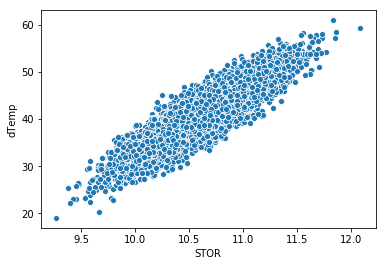

In [144]:
sns.scatterplot(x=df.STOR,y=df.dTemp)

,STOR,dT_RTG,dT_RSG,dTemp
count,10000.00,10000.00,10000.00,10000.00
mean,10.63,23.72,17.24,40.96
std,0.35,2.35,3.10,5.33
min,9.27,11.95,3.00,19.03
25%,10.40,22.20,15.16,37.41
50%,10.63,23.74,17.24,40.95
75%,10.86,25.27,19.34,44.53
max,12.08,32.70,28.29,60.99


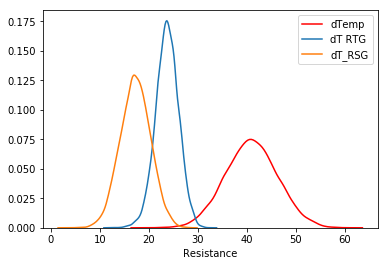

In [145]:
sns.distplot(df['dTemp'],hist=False,label='dTemp',color='r');
sns.distplot(df['dT_RTG'],hist=False,label="dT RTG");
sns.distplot(df['dT_RSG'],hist=False,label="dT_RSG");
plt.xlabel("Resistance")


df.describe().to_csv('RTG 20%, RSG: 10%, all lead 5%')
df[['STOR','dT_RTG','dT_RSG','dTemp']].describe().round(2)

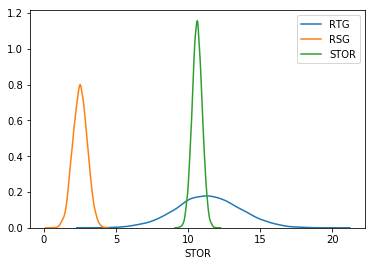

In [146]:


sns.distplot(df['RT'],hist=False,label="RTG");
sns.distplot(df['RS'],hist=False,label="RSG");
sns.distplot(df['STOR'],hist=False,label="STOR",);
# plt.xlim(left=4.7, right=6.5)
